# tutorial https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Note to Jose
Working version but not fully understood yet
The next commented think can allow to remove stuff

In [11]:
# Download TorchVision repo to use some files from
# references/detection
!git clone git@github.com:jcmayoral/PyTorch-YOLOv3.git yolov3

fatal: destination path 'yolov3' already exists and is not an empty directory.


In [12]:
from yolov3.models import Darknet

model_2classes = Darknet(config_path="yolov3/config/yolov3-custom.cfg")

In [13]:
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
    
    def concat_masks(self, mask):
        pshape = mask.shape
        arr = np.zeros((pshape[2],pshape[3]),dtype=np.uint8)
        #for i in range(pshape[0]):
        #    arr += mask[i,0].mul(255).byte().cpu().numpy()
        return Image.fromarray(arr)

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        #target["safety_level"] = 0.5

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [14]:
nparams = sum(p.numel() for p in model_2classes.parameters())
print (f"{nparams:,}")

61,529,119


In [15]:
!ls
!pwd

'attempt yolo.ipynb'		   __pycache__
 checkpoints			   scalar
 coco_eval.py			   svmpersons.ipynb
 coco_utils.py			   testingyolo
 decisiontreepersons.ipynb	   transforms.py
 engine.py			   Untitled1.ipynb
 linearregressionpersons.ipynb	   Untitled.ipynb
 logisticregressionpersons.ipynb   utils.py
 output				   vision
 pointnet.ipynb			   yolov3
/home/jose/ros_ws/src/gr_perception/gr_ml/nb


In [16]:
from __future__ import division

from yolov3.models import *
from yolov3.utils.logger import *
from yolov3.utils.utils import *
from yolov3.utils.datasets import *
from yolov3.utils.parse_config import *
from yolov3.test import evaluate

from terminaltables import AsciiTable

import os
import sys
import time
import datetime
import argparse

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim


"""
parser.add_argument("--epochs", type=int, default=100, help="number of epochs")
parser.add_argument("--batch_size", type=int, default=8, help="size of each image batch")
parser.add_argument("--gradient_accumulations", type=int, default=2, help="number of gradient accums before step")
parser.add_argument("--model_def", type=str, default="config/yolov3.cfg", help="path to model definition file")
parser.add_argument("--data_config", type=str, default="config/coco.data", help="path to data config file")
parser.add_argument("--pretrained_weights", type=str, help="if specified starts from checkpoint model")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_size", type=int, default=416, help="size of each image dimension")
parser.add_argument("--checkpoint_interval", type=int, default=1, help="interval between saving model weights")
parser.add_argument("--evaluation_interval", type=int, default=1, help="interval evaluations on validation set")
parser.add_argument("--compute_map", default=False, help="if True computes mAP every tenth batch")
parser.add_argument("--multiscale_training", default=True, help="allow for multi-scale training")
opt = parser.parse_args()
print(opt)
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Get data configuration
data_config = parse_data_config("yolov3/config/jose.data")
#data_config = { line.split()[0] : line.split()[1] for line in open("yolov3/config/jose.data") }

#parse_data_config(opt.data_config)bb
train_path = data_config["train"]
valid_path = data_config["valid"]
class_names = ["person", "background"]#load_classes(data_config["names"])

# Initiate model
model = Darknet("yolov3/config/yolov3-custom.cfg").to(device)
model.apply(weights_init_normal)

# If specified we start from checkpoint
"""
if opt.pretrained_weights:
    if opt.pretrained_weights.endswith(".pth"):
        model.load_state_dict(torch.load(opt.pretrained_weights))
    else:
        model.load_darknet_weights(opt.pretrained_weights)
"""



'\nif opt.pretrained_weights:\n    if opt.pretrained_weights.endswith(".pth"):\n        model.load_state_dict(torch.load(opt.pretrained_weights))\n    else:\n        model.load_darknet_weights(opt.pretrained_weights)\n'

In [17]:
bs = 1
nepochs = 10
ncpu = 1
gradient_accumulations = 1
evaluation_interval = 2
checkpoint_interval = 2
img_size = 416

In [18]:
!pwd


/home/jose/ros_ws/src/gr_perception/gr_ml/nb


In [19]:
# Get dataloader
dataset = ListDataset(train_path, augment=True, multiscale=True)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=ncpu,
    pin_memory=True,
    collate_fn=dataset.collate_fn,
)

optimizer = torch.optim.Adam(model.parameters())

metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]

try:
    os.makedirs("testingyolo")
except:
    pass

#logger = Logger("testingyolo/logs")


for epoch in range(nepochs):
    model.train()
    start_time = time.time()
    for batch_i, (_, imgs, targets) in enumerate(dataloader):
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % gradient_accumulations:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------

        log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, nepochs, batch_i, len(dataloader))

        metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

        # Log metrics at each YOLO layer
        for i, metric in enumerate(metrics):
            formats = {m: "%.6f" for m in metrics}
            formats["grid_size"] = "%2d"
            formats["cls_acc"] = "%.2f%%"
            row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
            metric_table += [[metric, *row_metrics]]

            # Tensorboard logging
            tensorboard_log = []
            for j, yolo in enumerate(model.yolo_layers):
                for name, metric in yolo.metrics.items():
                    if name != "grid_size":
                        tensorboard_log += [(f"{name}_{j+1}", metric)]
            tensorboard_log += [("loss", loss.item())]
            #logger.list_of_scalars_summary(tensorboard_log, batches_done)

        log_str += AsciiTable(metric_table).table
        log_str += f"\nTotal loss {loss.item()}"

        # Determine approximate time left for epoch
        epoch_batches_left = len(dataloader) - (batch_i + 1)
        time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
        log_str += f"\n---- ETA {time_left}"

        print(log_str)

        model.seen += imgs.size(0)

    if epoch % evaluation_interval == 0:
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
            model,
            path=valid_path,
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=img_size,
            batch_size=8,
        )
        """
        evaluation_metrics = [
            ("val_precision", precision.mean()),
            ("val_recall", recall.mean()),
            ("val_mAP", AP.mean()),
            ("val_f1", f1.mean()),
        ]
        logger.list_of_scalars_summary(evaluation_metrics, epoch)
        """
        # Print class APs and mAP
        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
        print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean()}")

    if epoch % checkpoint_interval == 0:
        torch.save(model.state_dict(), f"testingyolo/checkpoints/yolov3_ckpt_%d.pth" % epoch)


/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please 

Detecting objects:   0%|          | 0/1 [00:00<?, ?it/s]


---- [Epoch 0/10, Batch 0/1] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 60.295685    | 79.473671    | 74.739441    |
| x          | 0.015276     | 0.084966     | 0.017079     |
| y          | 0.034311     | 0.159627     | 0.270921     |
| w          | 0.016528     | 1.072483     | 0.244516     |
| h          | 1.337673     | 1.698977     | 3.293812     |
| conf       | 58.112648    | 75.728477    | 70.341911    |
| cls        | 0.779248     | 0.729142     | 0.571205     |
| cls_acc    | 0.00%        | 0.00%        | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.638472     | 0.674301     | 0.737667     |
| con

Computing AP: 100%|██████████| 1/1 [00:00<00:00, 159.93it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | person     | 0.00000 |
+-------+------------+---------+
---- mAP 0.0


/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please 


---- [Epoch 1/10, Batch 0/1] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 62.753441    | 77.992882    | 76.798653    |
| x          | 0.356227     | 0.013083     | 0.035750     |
| y          | 0.176242     | 0.245510     | 0.348810     |
| w          | 0.032278     | 0.016804     | 0.009257     |
| h          | 2.524069     | 1.163724     | 5.096004     |
| conf       | 58.864052    | 75.811935    | 70.630737    |
| cls        | 0.800573     | 0.741833     | 0.678094     |
| cls_acc    | 0.00%        | 0.00%        | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.258643     | 0.706509     | 0.548748     |
| con

/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please 

Detecting objects:   0%|          | 0/1 [00:00<?, ?it/s]


---- [Epoch 2/10, Batch 0/1] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 60.295685    | 79.473671    | 74.739441    |
| x          | 0.015276     | 0.084966     | 0.017079     |
| y          | 0.034311     | 0.159627     | 0.270921     |
| w          | 0.016528     | 1.072483     | 0.244516     |
| h          | 1.337673     | 1.698977     | 3.293812     |
| conf       | 58.112648    | 75.728477    | 70.341911    |
| cls        | 0.779248     | 0.729142     | 0.571205     |
| cls_acc    | 0.00%        | 0.00%        | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.638472     | 0.674301     | 0.737667     |
| con

Computing AP: 100%|██████████| 1/1 [00:00<00:00, 220.29it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | person     | 0.00059 |
+-------+------------+---------+
---- mAP 0.0005851375073142189


/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please 


---- [Epoch 3/10, Batch 0/1] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 15           | 30           | 60           |
| loss       | 60.295685    | 79.473671    | 74.739441    |
| x          | 0.015276     | 0.084966     | 0.017079     |
| y          | 0.034311     | 0.159627     | 0.270921     |
| w          | 0.016528     | 1.072483     | 0.244516     |
| h          | 1.337673     | 1.698977     | 3.293812     |
| conf       | 58.112648    | 75.728477    | 70.341911    |
| cls        | 0.779248     | 0.729142     | 0.571205     |
| cls_acc    | 0.00%        | 0.00%        | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.638472     | 0.674301     | 0.737667     |
| con

/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please 

Detecting objects:   0%|          | 0/1 [00:00<?, ?it/s]


---- [Epoch 4/10, Batch 0/1] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 62.429607    | 78.223602    | 72.619492    |
| x          | 0.055644     | 0.027521     | 0.000449     |
| y          | 0.181144     | 0.143642     | 0.248380     |
| w          | 2.339464     | 0.235264     | 0.000280     |
| h          | 0.661225     | 1.396760     | 1.246321     |
| conf       | 58.372715    | 75.886528    | 70.548622    |
| cls        | 0.819416     | 0.533887     | 0.575439     |
| cls_acc    | 0.00%        | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.367776     | 0.640295     | 0.606579     |
| con

Computing AP: 100%|██████████| 1/1 [00:00<00:00, 137.30it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | person     | 0.00000 |
+-------+------------+---------+
---- mAP 0.0


/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please 


---- [Epoch 5/10, Batch 0/1] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 12           | 24           | 48           |
| loss       | 62.846893    | 80.009926    | 74.085121    |
| x          | 0.167741     | 0.078714     | 0.000543     |
| y          | 0.141952     | 0.521228     | 0.177919     |
| w          | 1.509158     | 0.005502     | 0.073634     |
| h          | 1.503768     | 3.066176     | 2.531810     |
| conf       | 58.556114    | 75.715866    | 70.592598    |
| cls        | 0.968161     | 0.622435     | 0.708622     |
| cls_acc    | 0.00%        | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.406572     | 0.739965     | 0.547944     |
| con

/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please 

Detecting objects:   0%|          | 0/1 [00:00<?, ?it/s]


---- [Epoch 6/10, Batch 0/1] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 62.429607    | 78.223602    | 72.619492    |
| x          | 0.055644     | 0.027521     | 0.000449     |
| y          | 0.181144     | 0.143642     | 0.248380     |
| w          | 2.339464     | 0.235264     | 0.000280     |
| h          | 0.661225     | 1.396760     | 1.246321     |
| conf       | 58.372715    | 75.886528    | 70.548622    |
| cls        | 0.819416     | 0.533887     | 0.575439     |
| cls_acc    | 0.00%        | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.367776     | 0.640295     | 0.606579     |
| con

Computing AP: 100%|██████████| 1/1 [00:00<00:00, 202.13it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | person     | 0.00162 |
+-------+------------+---------+
---- mAP 0.0016181229773462784


/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please 


---- [Epoch 7/10, Batch 0/1] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 11           | 22           | 44           |
| loss       | 60.585049    | 77.837379    | 73.718048    |
| x          | 0.010177     | 0.009777     | 0.001749     |
| y          | 0.000141     | 0.345679     | 0.343490     |
| w          | 1.988303     | 0.178152     | 0.200548     |
| h          | 0.018635     | 0.965439     | 1.621643     |
| conf       | 57.701675    | 75.628090    | 70.766602    |
| cls        | 0.866116     | 0.710247     | 0.784020     |
| cls_acc    | 0.00%        | 0.00%        | 0.00%        |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.738574     | 0.755734     | 0.473754     |
| con

/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please 

Detecting objects:   0%|          | 0/1 [00:00<?, ?it/s]


---- [Epoch 8/10, Batch 0/1] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 13           | 26           | 52           |
| loss       | 60.876446    | 79.277748    | 73.799538    |
| x          | 0.100632     | 0.200994     | 0.004388     |
| y          | 0.052524     | 0.208207     | 0.325301     |
| w          | 0.093488     | 0.399950     | 0.157265     |
| h          | 1.198521     | 1.780464     | 2.156162     |
| conf       | 58.469208    | 75.892067    | 70.548004    |
| cls        | 0.962073     | 0.796064     | 0.608420     |
| cls_acc    | 0.00%        | 0.00%        | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.468670     | 0.651380     | 0.586884     |
| con

Computing AP: 100%|██████████| 1/1 [00:00<00:00, 138.68it/s]


+-------+------------+---------+
| Index | Class name | AP      |
+-------+------------+---------+
| 0     | person     | 0.00000 |
+-------+------------+---------+
---- mAP 0.0


/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/tmp/pip-req-build-4baxydiv/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please 


---- [Epoch 9/10, Batch 0/1] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 10           | 20           | 40           |
| loss       | 62.429607    | 78.223602    | 72.619492    |
| x          | 0.055644     | 0.027521     | 0.000449     |
| y          | 0.181144     | 0.143642     | 0.248380     |
| w          | 2.339464     | 0.235264     | 0.000280     |
| h          | 0.661225     | 1.396760     | 1.246321     |
| conf       | 58.372715    | 75.886528    | 70.548622    |
| cls        | 0.819416     | 0.533887     | 0.575439     |
| cls_acc    | 0.00%        | 100.00%      | 100.00%      |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.367776     | 0.640295     | 0.606579     |
| con

In [27]:
a,b,c = next(iter(dataloader))

In [28]:
a

['yolov3/data/custom/images/train.jpg']

In [30]:
b.shape

torch.Size([1, 3, 512, 512])

In [32]:
c

tensor([[0.0000, 0.0000, 0.4900, 0.5000, 0.1454, 0.1829]])

In [38]:
labels=[]

In [40]:
#list of pixels?
labels += c[:, 1].tolist()
# Rescale target
#targets[:, 2:] = xywh2xyxy(targets[:, 2:])
#targets[:, 2:] *= img_size


In [70]:
print(imgs.shape)
arr = imgs.cpu().mul(255).permute(0,2,3,1).byte().numpy()
print(arr[0].shape, arr[0].dtype)

torch.Size([1, 3, 320, 320])
(320, 320, 3) uint8


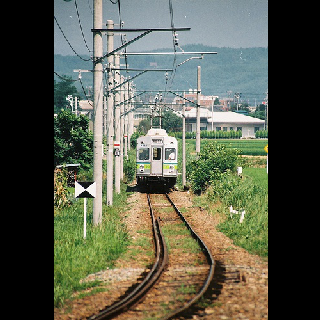

In [72]:
Image.fromarray(arr[0])

In [89]:
conf_thres = 0.001
nms_thres = 0.5

In [90]:
model.eval()
with torch.no_grad():
    outputs = model(imgs)
    outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)


In [114]:
#(x1, y1, x2, y2, object_conf, class_score, class_pred)
outputs[0].shape

torch.Size([4430, 7])

In [130]:
boxes = outputs[0].cpu().numpy()[:,:4]
boxes.shape

(4430, 4)

In [132]:
imgs.shape

torch.Size([1, 3, 320, 320])

In [163]:
def get_rect(x, y, width, height):
    rect = [(x, y), (x+width, y), (x+width, y+height), (x, y+height), (x, y)]
    #rect = [(0, 0), (width, height)]
    return tuple(rect)

(320, 320) RGB


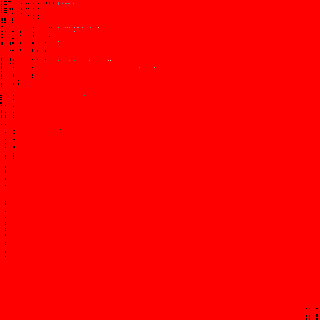

In [175]:
from PIL import ImageDraw

image = Image.fromarray(arr[0])
print (image.size, image.mode)
pshape = imgs.shape

#overlay = Image.new("L", (pshape[3], pshape[2]), 0)
#draw = ImageDraw.Draw(overlay)
draw = ImageDraw.Draw(image)

rects = [get_rect(*p) for p in boxes]

for rect in rects:
    draw.line([tuple(p) for p in rect], width=1, fill=255)

    
#img = Image.merge("RGB", (image,overlay,image))
image

In [ ]:
# pick one image from the test set
img, img2 = dataset_test[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
print(img2.keys())
print(img2['boxes'])
mshape = img2['masks'].shape
arr = np.zeros((mshape[1],mshape[2]),dtype=np.uint8)
for i in range(mshape[0]):
    print ("load")
    arr += img2['masks'][i].mul(255).byte().numpy()
print (arr, np.unique(arr), arr.shape, type(arr))
image = Image.fromarray(arr)
image

In [ ]:
def get_rect(x, y, width, height):
    rect = [(x, y), (x+width, y), (x+width, y+height), (x, y+height), (x, y)]
    #rect = [(0, 0), (width, height)]
    
    return tuple(rect)

In [ ]:
from PIL import ImageDraw
pshape = prediction[0]['masks'].shape
boxes = prediction[0]['boxes'].cpu().numpy()
print(prediction[0]['masks'].shape)

arr = np.zeros((pshape[2],pshape[3]),dtype=np.uint8)
for i in range(pshape[0]):
    arr += prediction[0]['masks'][i,0].mul(255).byte().cpu().numpy()
image = Image.fromarray(arr)


overlay = Image.new("L", (pshape[3], pshape[2]), 0)
draw = ImageDraw.Draw(overlay)
rects = [get_rect(*p) for p in boxes]

for rect in rects:
    draw.line([tuple(p) for p in rect], width=3, fill=500)


print(image.size)
print(overlay.size)

img = Image.merge("RGB", (image,overlay,image))
(image,overlay)
img